<a href="https://colab.research.google.com/github/maya2d26/CNN_dog_breed_classifier/blob/work/Stanford_dog_breed_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [10]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

# Reading the data

Download and extract images

In [11]:
! wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
! tar -xf ./images.tar &>/dev/null

--2022-03-02 23:32:57--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar.2’

images.tar.2        100%[===================>] 756.82M  21.4MB/s    in 42s     

2022-03-02 23:33:39 (17.9 MB/s) - ‘images.tar.2’ saved [793579520/793579520]



In [ ]:
!ls /content/Images/ -a

.					  n02100236-German_short-haired_pointer
..					  n02100583-vizsla
n02085620-Chihuahua			  n02100735-English_setter
n02085782-Japanese_spaniel		  n02100877-Irish_setter
n02085936-Maltese_dog			  n02101006-Gordon_setter
n02086079-Pekinese			  n02101388-Brittany_spaniel
n02086240-Shih-Tzu			  n02101556-clumber
n02086646-Blenheim_spaniel		  n02102040-English_springer
n02086910-papillon			  n02102177-Welsh_springer_spaniel
n02087046-toy_terrier			  n02102318-cocker_spaniel
n02087394-Rhodesian_ridgeback		  n02102480-Sussex_spaniel
n02088094-Afghan_hound			  n02102973-Irish_water_spaniel
n02088238-basset			  n02104029-kuvasz
n02088364-beagle			  n02104365-schipperke
n02088466-bloodhound			  n02105056-groenendael
n02088632-bluetick			  n02105162-malinois
n02089078-black-and-tan_coonhound	  n02105251-briard
n02089867-Walker_hound			  n02105412-kelpie
n02089973-English_foxhound		  n02105505-komondor
n02090379-redbone			  n02105641-Old_English_sheepdog
n02090622-borzoi			  n02105855-Shetlan

In [12]:
#choosing the 3 breeds
def isUsed(directory):
  return (os.path.basename(directory) == "n02088364-beagle" 
          or os.path.basename(directory) == "n02110185-Siberian_husky" 
          or os.path.basename(directory) == "n02112018-Pomeranian" )
  
#turning breed names into numbers
def breed_to_num(breed):
  if(breed == "Pomeranian"):
    return 0
  if(breed == "Siberian husky"):
    return 1
  if(breed == "beagle"):
    return 2
  return -1
    

In [15]:
! pip uninstall opencv-python-headless==4.5.5.62

Found existing installation: opencv-python-headless 4.5.5.62
Uninstalling opencv-python-headless-4.5.5.62:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.62.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-64ac49e1.so.58.91.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-4b79e479.so.58.45.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-805734e8.so.56.51.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-018b8c17.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dist

In [16]:
! pip install opencv-python-headless==4.5.2.52

     |████████████████████████████████| 38.2 MB 2.1 MB/s 


In [17]:
from pathlib import Path
import cv2

images = []
breeds = []
labels = []

root = Path("./Images")
for dir in root.iterdir():
  if (isUsed(dir)):
    for f in dir.iterdir():
      images.append(cv2.cvtColor(cv2.imread(str(f)), cv2.COLOR_BGR2RGB))
      #creating more readable breed labels
      breed = ' '.join(' '.join(dir.name.split('-')[1:]).split('_'))
      breeds.append(breed)
      #using numbers to reperesent breeds
      labels.append(breed_to_num(breed))

df = pd.DataFrame(data={"img": images, "breed": breeds, "label":labels})
df.head()

,img,breed,label
0,"[[[50, 49, 45], [51, 50, 46], [52, 51, 47], [5...",beagle,2
1,"[[[246, 237, 228], [229, 220, 213], [210, 200,...",beagle,2
2,"[[[21, 21, 21], [85, 85, 85], [50, 50, 50], [6...",beagle,2
3,"[[[173, 84, 40], [174, 87, 44], [173, 88, 47],...",beagle,2
4,"[[[17, 15, 20], [18, 17, 22], [20, 19, 25], [1...",beagle,2


describing the dataset

In [18]:
print(df["label"][0],df["label"][300],df["label"][600])
print(df["breed"][0],df["breed"][300],df["breed"][600])

2 1 0
beagle Siberian husky Pomeranian


let's see an image!

beagle
500x381


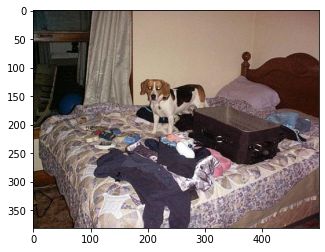

In [19]:
from random import randrange
rnd=randrange(len(df["img"]))
img = df["img"][rnd]
breed = df["breed"][rnd]
print(breed)
height, width, colour = img.shape
print(str(width)+"x"+ str(height))
plt.imshow(img)

# Splitting the data and augmentation

In [33]:
from tqdm import tqdm
from skimage.io import imread, imsave
train_img = []
train_label = []
for idx,row in tqdm(df.iterrows()):
    train_img.append(cv2.resize(row["img"],(350,350)))
    train_label.append(row["label"])

train_x_no_aug = np.array(train_img)
train_y_no_aug = df["label"].values
train_x_no_aug.shape, train_y_no_aug.shape

606it [00:02, 210.77it/s]


((606, 350, 350, 3), (606,))

splitting the data

In [34]:
from sklearn.model_selection import train_test_split
train_x_no_aug, test_x, train_y_no_aug, test_y = train_test_split(train_x_no_aug, train_y_no_aug, test_size = 0.2, random_state = 13, stratify=train_y_no_aug)
(train_x_no_aug.shape, train_y_no_aug.shape), (test_x.shape, test_y.shape)

(((484, 350, 350, 3), (484,)), ((122, 350, 350, 3), (122,)))

augmenting images

In [35]:
! pip install -U albumentations

In [36]:
import albumentations as A
transform = A.Compose([
    A.GaussNoise(mean=0,p=0.8),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomRotate90(p=0.6),
    A.ShiftScaleRotate(scale_limit=0.6,p=0.8),
    A.CLAHE(),
    A.Resize(height=350,width=350, p=1)
])

In [37]:
train_x= []
train_y = []
for i in tqdm(range(train_x_no_aug.shape[0])):
    img = train_x_no_aug[i]
    train_x.append(img)
    for j in range(5):
      train_x.append(transform(image=img)["image"])
    for j in range(6):
      train_y.append(train_y_no_aug[i])

len(train_x), len(train_y)

100%|██████████| 484/484 [01:20<00:00,  6.05it/s]


(2904, 2904)

In [38]:
for img in train_x:
  height, width, color = img.shape
  if (height!=350 or width!=350):
    print(width,height)

let's see the augmented images!

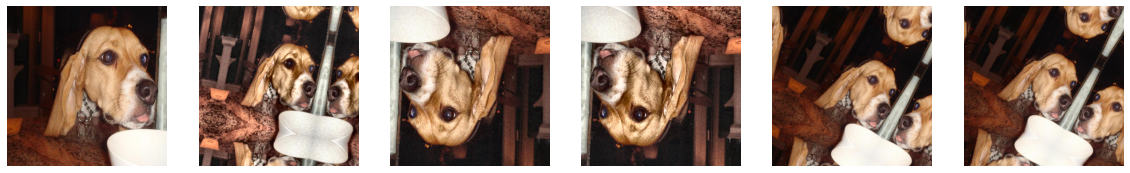

In [39]:
fig,ax = plt.subplots(nrows=1,ncols=6,figsize=(20,20))
dog_num=randrange(484)*6
for i in range(6):
    ax[i].imshow(train_x[i+dog_num])
    ax[i].axis('off')

In [40]:
train_x = np.array(train_x)
train_y = np.array(train_y)

# converting training images into torch format
#train_x = train_x.reshape(2904, 3, 224, 224)
train_x  = torch.from_numpy(train_x)
train_x = train_x.float()

# converting the target into torch format
#train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

Creating dataloaders

In [41]:
from torch.utils.data import TensorDataset, DataLoader

#train_tensor_x = torch.Tensor(train_x) 
#train_tensor_y = torch.Tensor(train_y)
#test_tensor_x = torch.Tensor(test_x) 
#test_tensor_y = torch.Tensor(test_y)

train_ds= TensorDataset(train_x,train_y)
test_ds = TensorDataset(test_x,test_y)

batch_size=32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)

TypeError: ignored

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for img in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img, nrow=16).permute(1,2,0))
        break

TypeError: ignored

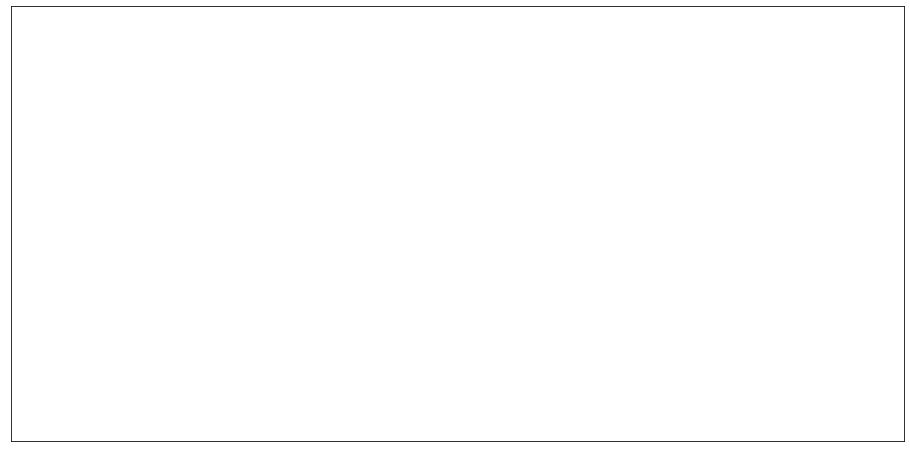

In [ ]:
show_batch(train_x)